In [43]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression


In [44]:
df = pd.read_csv("/content/df_file.csv")   # loading dataset
df.head()


,Text,Label
0,Budget to set scene for election\n \n Gordon B...,0
1,Army chiefs in regiments decision\n \n Militar...,0
2,Howard denies split over ID cards\n \n Michael...,0
3,Observers to monitor UK election\n \n Minister...,0
4,Kilroy names election seat target\n \n Ex-chat...,0


In [45]:
df = df[df['Label'].isin([0, 1])] #Keep only Politics and Sports data
df['Label'].value_counts()


,count
Label,
1,511
0,417


In [46]:
#Basic Datset Checks
print("Dataset Shape:", df.shape)
print("\nMissing Values:\n", df.isnull().sum())

Dataset Shape: (928, 2)

Missing Values:
 Text     0
Label    0
dtype: int64


In [47]:
#Duplicate Check
print("Duplicate documents:", df['Text'].duplicated().sum())

Duplicate documents: 20


In [48]:
#Drop Duplicates
df = df.drop_duplicates(subset=['Text'])
print("New dataset size:", df.shape)


New dataset size: (908, 2)


In [49]:
#Length analysis
df['length'] = df['Text'].apply(lambda x: len(x.split()))

df['length'].describe()


,length
count,908.000000
mean,386.367841
std,254.200246
min,89.000000
25%,242.750000
50%,349.000000
75%,484.000000
max,4432.000000


In [50]:
#Clip length to reasonable range
df = df[(df['length'] >= 50) & (df['length'] <= 400)]

print("Dataset after length filtering:", df.shape)


Dataset after length filtering: (527, 3)


In [62]:
#NLP Preprocessing
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', ' ', text)              # remove numbers
    text = re.sub(r'\s+', ' ', text)              # normalize spaces
    text = text.translate(str.maketrans('', '', string.punctuation))

    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    return " ".join(tokens)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [63]:
#Splitting Dataset
X_train, X_val, y_train, y_val = train_test_split(
    df['Text'],
    df['Label'],
    test_size=0.2,
    random_state=42,
    stratify=df['Label']
)

X_train_clean = X_train.apply(preprocess_text)
X_val_clean = X_val.apply(preprocess_text)



In [64]:
#Overlap Detection
train_set = set(X_train)
val_set = set(X_val)

overlap = train_set.intersection(val_set)

print("Number of overlapping documents:", len(overlap))


Number of overlapping documents: 0


In [65]:
#Remove Overlapping Samples if present
if len(overlap) > 0:
    df_no_overlap = df[~df['Text'].isin(overlap)]

    X_train, X_val, y_train, y_val = train_test_split(
        df_no_overlap['Text'],
        df_no_overlap['Label'],
        test_size=0.2,
        random_state=42,
        stratify=df_no_overlap['Label']
    )

    print("New split after removing overlaps:")
    print("Train:", len(X_train), "Validation:", len(X_val))
else:
    print("No leakage detected ✔️")


No leakage detected ✔️


In [66]:
#TF-IDF
# Convert text into numerical features using TF-IDF with controlled vocabulary to reduce overfitting.
# Unigrams + frequency thresholds help focus on informative words while ignoring noise.

vectorizer = TfidfVectorizer(
    ngram_range=(1, 1),
    max_features=3000,
    max_df=0.85,
    min_df=5,
    sublinear_tf=True
)

# Learn vocabulary only from training data to avoid data leakage; transform validation using same mapping.
# Ensures fair evaluation and realistic model performance estimation.

X_train_tfidf = vectorizer.fit_transform(X_train_clean)
X_val_tfidf = vectorizer.transform(X_val_clean)

print("TF-IDF Shape:", X_train_tfidf.shape)


TF-IDF Shape: (421, 1963)


In [67]:
#Train Models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": LinearSVC(),
    "Logistic Regression": LogisticRegression(max_iter=1000)
}

results = {}
#Evaluate Models
for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    preds = model.predict(X_val_tfidf)

    acc = accuracy_score(y_val, preds)
    results[name] = acc

    print(f"\n{name}")
    print("Accuracy:", acc)



Random Forest
Accuracy: 0.9716981132075472

SVM
Accuracy: 0.9905660377358491

Logistic Regression
Accuracy: 0.9528301886792453


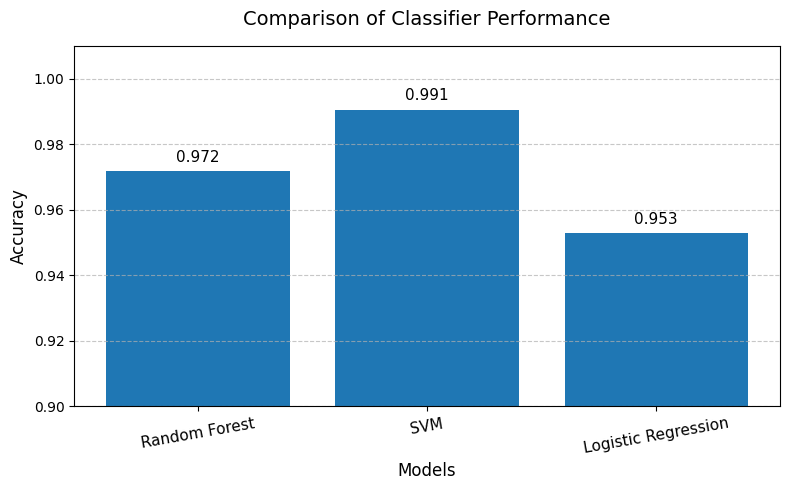

In [68]:
#Accuracy Comparison Plot
plt.figure(figsize=(8, 5))

bars = plt.bar(results.keys(), results.values())

plt.title("Comparison of Classifier Performance", fontsize=14, pad=15)
plt.ylabel("Accuracy", fontsize=12)
plt.xlabel("Models", fontsize=12)

plt.ylim(0.9, 1.01)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.xticks(rotation=10, fontsize=11)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.002,
        f"{height:.3f}",
        ha='center',
        va='bottom',
        fontsize=11
    )

plt.tight_layout()
plt.show()



In [69]:
#Confusion Matrix Function
def plot_conf_matrix(model, model_name):
    preds = model.predict(X_val_tfidf)
    cm = confusion_matrix(y_val, preds)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f"Confusion Matrix — {model_name}")
    plt.show()


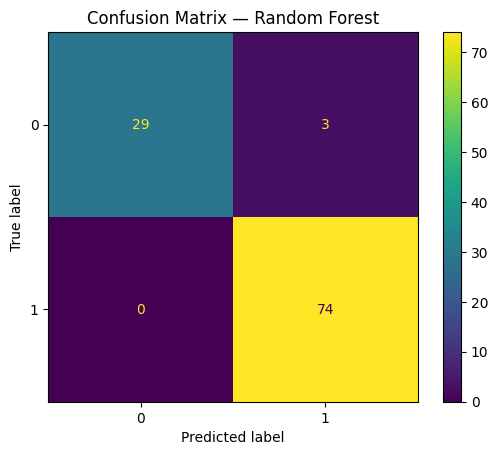

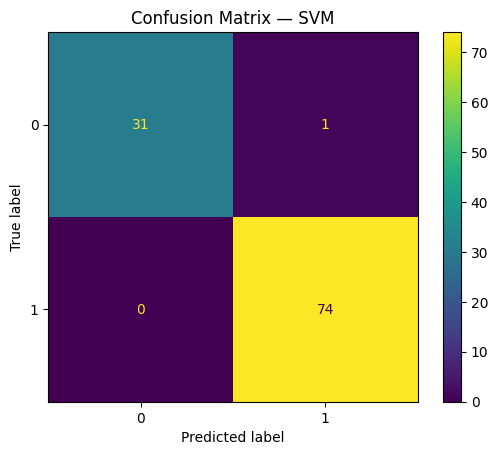

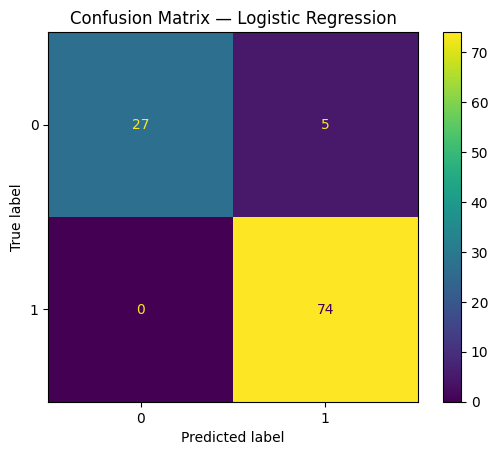

In [70]:
for name, model in models.items():
    plot_conf_matrix(model, name)


In [71]:
from sklearn.model_selection import cross_val_score

svm = LinearSVC()

scores = cross_val_score(svm, X_train_tfidf, y_train, cv=5)

print("Cross-validation scores:", scores)
print("Mean CV accuracy:", scores.mean())


Cross-validation scores: [0.98823529 1.         0.98809524 1.         1.        ]
Mean CV accuracy: 0.9952661064425771
